# ChatOpenAI

This notebook provides a quick overview for getting started with OpenAI [chat models](/docs/concepts/chat_models). For detailed documentation of all ChatOpenAI features and configurations head to the [API reference](https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html).

OpenAI has several chat models. You can find information about their latest models and their costs, context windows, and supported input types in the [OpenAI docs](https://platform.openai.com/docs/models).

:::info Azure OpenAI

Note that certain OpenAI models can also be accessed via the [Microsoft Azure platform](https://azure.microsoft.com/en-us/products/ai-services/openai-service). To use the Azure OpenAI service use the [AzureChatOpenAI integration](/docs/integrations/chat/azure_chat_openai/).

:::

## Overview

### Integration details
| Class | Package | Local | Serializable | [JS support](https://js.langchain.com/docs/integrations/chat/openai) | Package downloads | Package latest |
| :--- | :--- | :---: | :---: |  :---: | :---: | :---: |
| [ChatOpenAI](https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html) | [langchain-openai](https://python.langchain.com/api_reference/openai/index.html) | ❌ | beta | ✅ | ![PyPI - Downloads](https://img.shields.io/pypi/dm/langchain-openai?style=flat-square&label=%20) | ![PyPI - Version](https://img.shields.io/pypi/v/langchain-openai?style=flat-square&label=%20) |

### Model features
| [Tool calling](/docs/how_to/tool_calling) | [Structured output](/docs/how_to/structured_output/) | JSON mode | Image input | Audio input | Video input | [Token-level streaming](/docs/how_to/chat_streaming/) | Native async | [Token usage](/docs/how_to/chat_token_usage_tracking/) | [Logprobs](/docs/how_to/logprobs/) |
| :---: | :---: | :---: | :---: |  :---: | :---: | :---: | :---: | :---: | :---: |
| ✅ | ✅ | ✅ | ✅ | ✅ | ❌ | ✅ | ✅ | ✅ | ✅ | 

## Setup

To access OpenAI models you'll need to create an OpenAI account, get an API key, and install the `langchain-openai` integration package.

### Credentials

Head to https://platform.openai.com to sign up to OpenAI and generate an API key. Once you've done this set the OPENAI_API_KEY environment variable:

In [1]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

If you want to get automated tracing of your model calls you can also set your [LangSmith](https://docs.smith.langchain.com/) API key by uncommenting below:

In [2]:
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")
# os.environ["LANGSMITH_TRACING"] = "true"

### Installation

The LangChain OpenAI integration lives in the `langchain-openai` package:

In [ ]:
%pip install -qU langchain-openai

## Instantiation

Now we can instantiate our model object and generate chat completions:

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # api_key="...",  # if you prefer to pass api key in directly instaed of using env vars
    # base_url="...",
    # organization="...",
    # other params...
)

## Invocation

In [3]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content="J'adore la programmation.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 5, 'prompt_tokens': 31, 'total_tokens': 36}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-63219b22-03e3-4561-8cc4-78b7c7c3a3ca-0', usage_metadata={'input_tokens': 31, 'output_tokens': 5, 'total_tokens': 36})

In [4]:
print(ai_msg.content)

J'adore la programmation.


## Chaining

We can [chain](/docs/how_to/sequence/) our model with a prompt template like so:

In [5]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that translates {input_language} to {output_language}.",
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm
chain.invoke(
    {
        "input_language": "English",
        "output_language": "German",
        "input": "I love programming.",
    }
)

AIMessage(content='Ich liebe das Programmieren.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 26, 'total_tokens': 32}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-350585e1-16ca-4dad-9460-3d9e7e49aaf1-0', usage_metadata={'input_tokens': 26, 'output_tokens': 6, 'total_tokens': 32})

## Tool calling

OpenAI has a [tool calling](https://platform.openai.com/docs/guides/function-calling) (we use "tool calling" and "function calling" interchangeably here) API that lets you describe tools and their arguments, and have the model return a JSON object with a tool to invoke and the inputs to that tool. tool-calling is extremely useful for building tool-using chains and agents, and for getting structured outputs from models more generally.

### ChatOpenAI.bind_tools()

With `ChatOpenAI.bind_tools`, we can easily pass in Pydantic classes, dict schemas, LangChain tools, or even functions as tools to the model. Under the hood these are converted to an OpenAI tool schemas, which looks like:
```
{
    "name": "...",
    "description": "...",
    "parameters": {...}  # JSONSchema
}
```
and passed in every model invocation.

In [6]:
from pydantic import BaseModel, Field


class GetWeather(BaseModel):
    """Get the current weather in a given location"""

    location: str = Field(..., description="The city and state, e.g. San Francisco, CA")


llm_with_tools = llm.bind_tools([GetWeather])

In [7]:
ai_msg = llm_with_tools.invoke(
    "what is the weather like in San Francisco",
)
ai_msg

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_o9udf3EVOWiV4Iupktpbpofk', 'function': {'arguments': '{"location":"San Francisco, CA"}', 'name': 'GetWeather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 68, 'total_tokens': 85}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1617c9b2-dda5-4120-996b-0333ed5992e2-0', tool_calls=[{'name': 'GetWeather', 'args': {'location': 'San Francisco, CA'}, 'id': 'call_o9udf3EVOWiV4Iupktpbpofk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 68, 'output_tokens': 17, 'total_tokens': 85})

### ``strict=True``

:::info Requires ``langchain-openai>=0.1.21``

:::

As of Aug 6, 2024, OpenAI supports a `strict` argument when calling tools that will enforce that the tool argument schema is respected by the model. See more here: https://platform.openai.com/docs/guides/function-calling

**Note**: If ``strict=True`` the tool definition will also be validated, and a subset of JSON schema are accepted. Crucially, schema cannot have optional args (those with default values). Read the full docs on what types of schema are supported here: https://platform.openai.com/docs/guides/structured-outputs/supported-schemas. 

In [8]:
llm_with_tools = llm.bind_tools([GetWeather], strict=True)
ai_msg = llm_with_tools.invoke(
    "what is the weather like in San Francisco",
)
ai_msg

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jUqhd8wzAIzInTJl72Rla8ht', 'function': {'arguments': '{"location":"San Francisco, CA"}', 'name': 'GetWeather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 68, 'total_tokens': 85}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5e3356a9-132d-4623-8e73-dd5a898cf4a6-0', tool_calls=[{'name': 'GetWeather', 'args': {'location': 'San Francisco, CA'}, 'id': 'call_jUqhd8wzAIzInTJl72Rla8ht', 'type': 'tool_call'}], usage_metadata={'input_tokens': 68, 'output_tokens': 17, 'total_tokens': 85})

### AIMessage.tool_calls
Notice that the AIMessage has a `tool_calls` attribute. This contains in a standardized ToolCall format that is model-provider agnostic.

In [9]:
ai_msg.tool_calls

[{'name': 'GetWeather',
  'args': {'location': 'San Francisco, CA'},
  'id': 'call_jUqhd8wzAIzInTJl72Rla8ht',
  'type': 'tool_call'}]

For more on binding tools and tool call outputs, head to the [tool calling](/docs/how_to/function_calling) docs.

### Structured output and tool calls

OpenAI's [structured output](https://platform.openai.com/docs/guides/structured-outputs) feature can be used simultaneously with tool-calling. The model will either generate tool calls or a response adhering to a desired schema. See example below:

In [ ]:
from langchain_openai import ChatOpenAI
from pydantic import BaseModel


def get_weather(location: str) -> None:
    """Get weather at a location."""
    return "It's sunny."


class OutputSchema(BaseModel):
    """Schema for response."""

    answer: str
    justification: str


llm = ChatOpenAI(model="gpt-4.1")

structured_llm = llm.bind_tools(
    [get_weather],
    response_format=OutputSchema,
    strict=True,
)

# Response contains tool calls:
tool_call_response = structured_llm.invoke("What is the weather in SF?")

# structured_response.additional_kwargs["parsed"] contains parsed output
structured_response = structured_llm.invoke(
    "What weighs more, a pound of feathers or a pound of gold?"
)

### Custom tools

:::info Requires ``langchain-openai>=0.3.29``

:::

[Custom tools](https://platform.openai.com/docs/guides/function-calling#custom-tools) support tools with arbitrary string inputs. They can be particularly useful when you expect your string arguments to be long or complex.

In [1]:
from langchain_openai import ChatOpenAI, custom_tool
from langgraph.prebuilt import create_react_agent


@custom_tool
def execute_code(code: str) -> str:
    """Execute python code."""
    return "27"


llm = ChatOpenAI(model="gpt-5", output_version="responses/v1")

agent = create_react_agent(llm, [execute_code])

input_message = {"role": "user", "content": "Use the tool to calculate 3^3."}
for step in agent.stream(
    {"messages": [input_message]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Use the tool to calculate 3^3.
================================== Ai Message ==================================

[{'id': 'rs_6894ff5747c0819d9b02fc5645b0be9c000169fd9fb68d99', 'summary': [], 'type': 'reasoning'}, {'call_id': 'call_7SYwMSQPbbEqFcKlKOpXeEux', 'input': 'print(3**3)', 'name': 'execute_code', 'type': 'custom_tool_call', 'id': 'ctc_6894ff5b9f54819d8155a63638d34103000169fd9fb68d99', 'status': 'completed'}]
Tool Calls:
  execute_code (call_7SYwMSQPbbEqFcKlKOpXeEux)
 Call ID: call_7SYwMSQPbbEqFcKlKOpXeEux
  Args:
    __arg1: print(3**3)
================================= Tool Message =================================
Name: execute_code

[{'type': 'custom_tool_call_output', 'output': '27'}]
================================== Ai Message ==================================

[{'type': 'text', 'text': '27', 'annotations': [], 'id': 'msg_6894ff5db3b8819d9159b3a370a25843000169fd9fb68d99'}]


<details>
<summary>Context-free grammars</summary>

OpenAI supports the specification of a [context-free grammar](https://platform.openai.com/docs/guides/function-calling#context-free-grammars) for custom tool inputs in `lark` or `regex` format. See [OpenAI docs](https://platform.openai.com/docs/guides/function-calling#context-free-grammars) for details. The `format` parameter can be passed into `@custom_tool` as shown below:

In [3]:
from langchain_openai import ChatOpenAI, custom_tool
from langgraph.prebuilt import create_react_agent

grammar = """
start: expr
expr: term (SP ADD SP term)* -> add
| term
term: factor (SP MUL SP factor)* -> mul
| factor
factor: INT
SP: " "
ADD: "+"
MUL: "*"
%import common.INT
"""

format = {"type": "grammar", "syntax": "lark", "definition": grammar}


# highlight-next-line
@custom_tool(format=format)
def do_math(input_string: str) -> str:
    """Do a mathematical operation."""
    return "27"


llm = ChatOpenAI(model="gpt-5", output_version="responses/v1")

agent = create_react_agent(llm, [do_math])

input_message = {"role": "user", "content": "Use the tool to calculate 3^3."}
for step in agent.stream(
    {"messages": [input_message]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Use the tool to calculate 3^3.
================================== Ai Message ==================================

[{'id': 'rs_689500828a8481a297ff0f98e328689c0681550c89797f43', 'summary': [], 'type': 'reasoning'}, {'call_id': 'call_jzH01RVhu6EFz7yUrOFXX55s', 'input': '3 * 3 * 3', 'name': 'do_math', 'type': 'custom_tool_call', 'id': 'ctc_6895008d57bc81a2b84d0993517a66b90681550c89797f43', 'status': 'completed'}]
Tool Calls:
  do_math (call_jzH01RVhu6EFz7yUrOFXX55s)
 Call ID: call_jzH01RVhu6EFz7yUrOFXX55s
  Args:
    __arg1: 3 * 3 * 3
================================= Tool Message =================================
Name: do_math

[{'type': 'custom_tool_call_output', 'output': '27'}]
================================== Ai Message ==================================

[{'type': 'text', 'text': '27', 'annotations': [], 'id': 'msg_6895009776b881a2a25f0be8507d08f20681550c89797f43'}]


</details>

## Responses API

:::info Requires ``langchain-openai>=0.3.9``

:::

OpenAI supports a [Responses](https://platform.openai.com/docs/guides/responses-vs-chat-completions) API that is oriented toward building [agentic](/docs/concepts/agents/) applications. It includes a suite of [built-in tools](https://platform.openai.com/docs/guides/tools?api-mode=responses), including web and file search. It also supports management of [conversation state](https://platform.openai.com/docs/guides/conversation-state?api-mode=responses), allowing you to continue a conversational thread without explicitly passing in previous messages, as well as the output from [reasoning processes](https://platform.openai.com/docs/guides/reasoning?api-mode=responses).

`ChatOpenAI` will route to the Responses API if one of these features is used. You can also specify `use_responses_api=True` when instantiating `ChatOpenAI`.

:::note

`langchain-openai >= 0.3.26` allows users to opt-in to an updated AIMessage format when using the Responses API. Setting

```python
llm = ChatOpenAI(model="...", output_version="responses/v1")
```
will format output from reasoning summaries, built-in tool invocations, and other response items into the message's `content` field, rather than `additional_kwargs`. We recommend this format for new applications.

:::

### Web search

To trigger a web search, pass `{"type": "web_search_preview"}` to the model as you would another tool.

:::tip

You can also pass built-in tools as invocation params:
```python
llm.invoke("...", tools=[{"type": "web_search_preview"}])
```

:::

In [1]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini", output_version="responses/v1")

tool = {"type": "web_search_preview"}
llm_with_tools = llm.bind_tools([tool])

response = llm_with_tools.invoke("What was a positive news story from today?")

Note that the response includes structured [content blocks](/docs/concepts/messages/#content-1) that include both the text of the response and OpenAI [annotations](https://platform.openai.com/docs/guides/tools-web-search?api-mode=responses#output-and-citations) citing its sources. The output message will also contain information from any tool invocations:

In [3]:
response.content

[{'id': 'ws_685d997c1838819e8a2cbf66059ddd5c0f6f330a19127ac1',
  'action': {'query': 'positive news stories today', 'type': 'search'},
  'status': 'completed',
  'type': 'web_search_call'},
 {'type': 'text',
  'text': "On June 25, 2025, the James Webb Space Telescope made a groundbreaking discovery by directly imaging a previously unknown exoplanet. This young gas giant, approximately the size of Saturn, orbits a star smaller than our Sun, located about 110 light-years away in the constellation Antlia. This achievement marks the first time Webb has identified an exoplanet not previously known, expanding our understanding of distant worlds. ([straitstimes.com](https://www.straitstimes.com/world/while-you-were-sleeping-5-stories-you-might-have-missed-june-26-2025?utm_source=openai))\n\nAdditionally, in the realm of conservation, a significant milestone was achieved with the successful translocation of seventy southern white rhinos from South Africa to Rwanda's Akagera National Park. This

:::tip

You can recover just the text content of the response as a string by using `response.text()`. For example, to stream response text:

```python
for token in llm_with_tools.stream("..."):
    print(token.text(), end="|")
```

See the [streaming guide](/docs/how_to/chat_streaming/) for more detail.

:::

### Image generation


:::info Requires ``langchain-openai>=0.3.19``
:::


To trigger an image generation, pass `{"type": "image_generation"}` to the model as you would another tool.

:::tip

You can also pass built-in tools as invocation params:
```python
llm.invoke("...", tools=[{"type": "image_generation"}])
```

:::

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini", output_version="responses/v1")

tool = {"type": "image_generation", "quality": "low"}

llm_with_tools = llm.bind_tools([tool])

ai_message = llm_with_tools.invoke(
    "Draw a picture of a cute fuzzy cat with an umbrella"
)

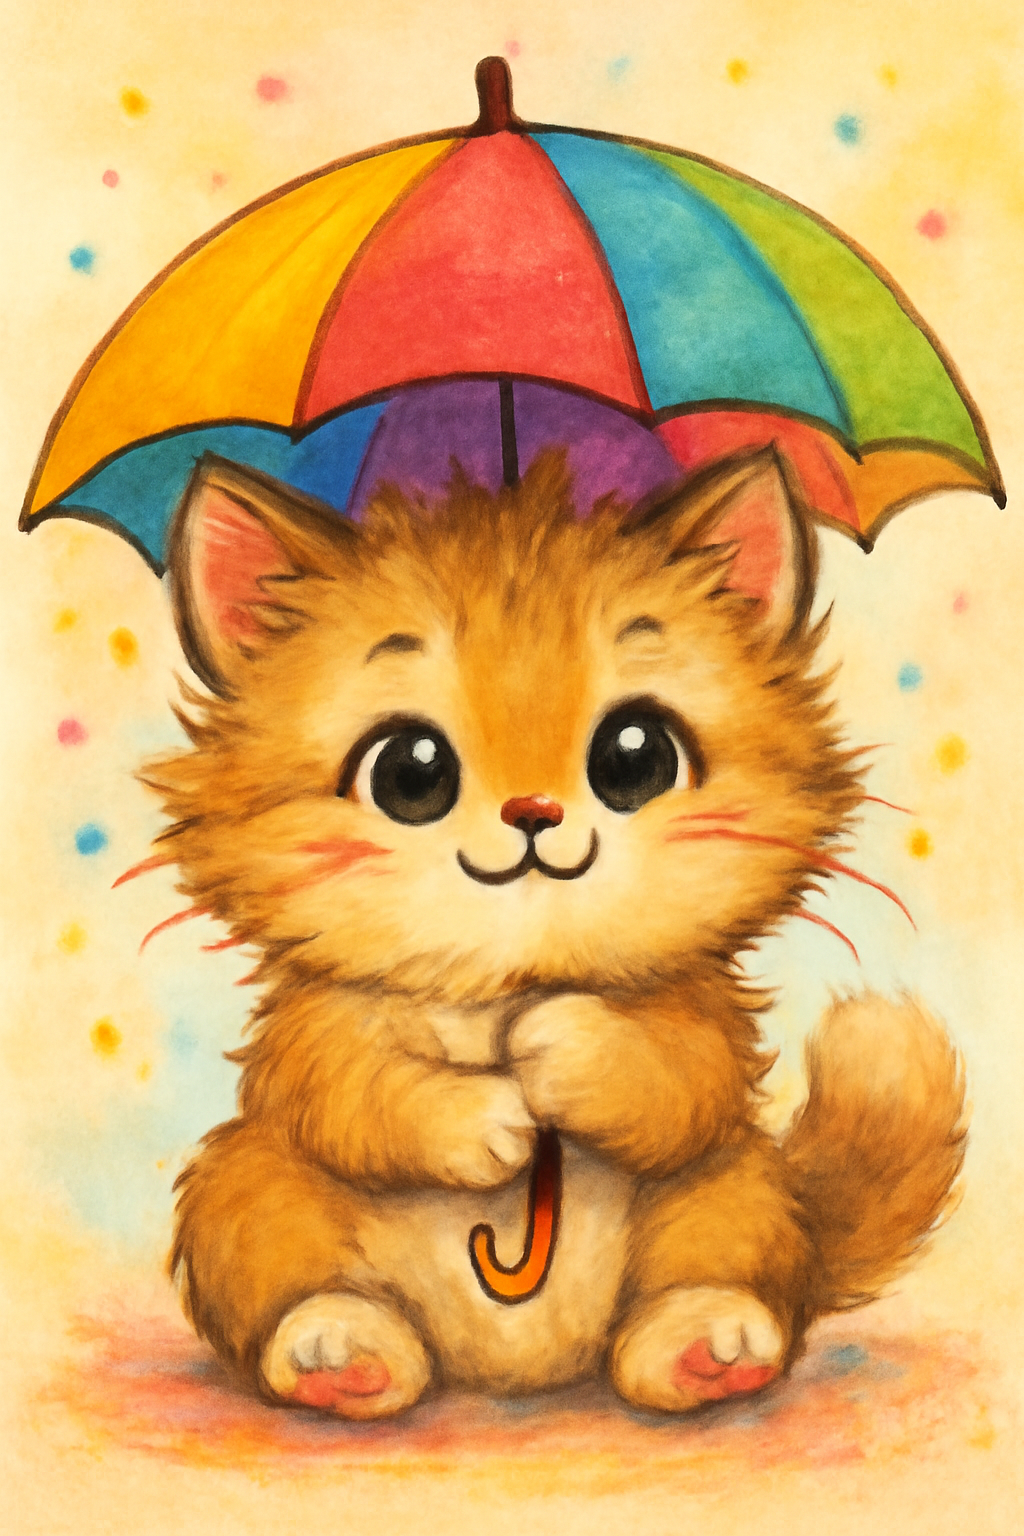

In [3]:
import base64

from IPython.display import Image

image = next(
    item for item in ai_message.content if item["type"] == "image_generation_call"
)
Image(base64.b64decode(image["result"]), width=200)

### File search

To trigger a file search, pass a [file search tool](https://platform.openai.com/docs/guides/tools-file-search) to the model as you would another tool. You will need to populate an OpenAI-managed vector store and include the vector store ID in the tool definition. See [OpenAI documentation](https://platform.openai.com/docs/guides/tools-file-search) for more detail.

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini", output_version="responses/v1")

openai_vector_store_ids = [
    "vs_...",  # your IDs here
]

tool = {
    "type": "file_search",
    "vector_store_ids": openai_vector_store_ids,
}
llm_with_tools = llm.bind_tools([tool])

response = llm_with_tools.invoke("What is deep research by OpenAI?")
print(response.text())

Deep Research by OpenAI is a newly launched agentic capability within ChatGPT designed to conduct complex, multi-step research tasks on the internet autonomously. It synthesizes large amounts of online information into comprehensive, research analyst-level reports, accomplishing in tens of minutes what would typically take a human many hours. This capability is powered by an upcoming OpenAI o3 model that is optimized for web browsing and data analysis, allowing it to search, interpret, and analyze massive amounts of text, images, and PDFs from the internet, while dynamically adjusting its approach based on the information it finds.

Key features of Deep Research include:
- Independent discovery, reasoning, and consolidation of insights from across the web.
- Ability to use browser and Python programming tools for data analysis and graph plotting.
- Full documentation of outputs with clear citations and a summary of its reasoning process, making it easy to verify and reference.
- Design

As with [web search](#web-search), the response will include content blocks with citations:

In [9]:
[block["type"] for block in response.content]

['file_search_call', 'text']

In [5]:
text_block = next(block for block in response.content if block["type"] == "text")

text_block["annotations"][:2]

[{'file_id': 'file-3UzgX7jcC8Dt9ZAFzywg5k',
  'filename': 'deep_research_blog.pdf',
  'index': 3121,
  'type': 'file_citation'},
 {'file_id': 'file-3UzgX7jcC8Dt9ZAFzywg5k',
  'filename': 'deep_research_blog.pdf',
  'index': 3121,
  'type': 'file_citation'}]

It will also include information from the built-in tool invocations:

In [8]:
response.content[0]

{'id': 'fs_685d9e7d48408191b9e34ad359069ede019138cfaaf3cea8',
 'queries': ['deep research by OpenAI'],
 'status': 'completed',
 'type': 'file_search_call'}

### Computer use

`ChatOpenAI` supports the `"computer-use-preview"` model, which is a specialized model for the built-in computer use tool. To enable, pass a [computer use tool](https://platform.openai.com/docs/guides/tools-computer-use) as you would pass another tool.

Currently, tool outputs for computer use are present in the message `content` field. To reply to the computer use tool call, construct a `ToolMessage` with `{"type": "computer_call_output"}` in its `additional_kwargs`. The content of the message will be a screenshot. Below, we demonstrate a simple example.

First, load two screenshots:

In [2]:
import base64


def load_png_as_base64(file_path):
    with open(file_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
        return encoded_string.decode("utf-8")


screenshot_1_base64 = load_png_as_base64(
    "/path/to/screenshot_1.png"
)  # perhaps a screenshot of an application
screenshot_2_base64 = load_png_as_base64(
    "/path/to/screenshot_2.png"
)  # perhaps a screenshot of the Desktop

In [3]:
from langchain_openai import ChatOpenAI

# Initialize model
llm = ChatOpenAI(
    model="computer-use-preview",
    truncation="auto",
    output_version="responses/v1",
)

# Bind computer-use tool
tool = {
    "type": "computer_use_preview",
    "display_width": 1024,
    "display_height": 768,
    "environment": "browser",
}
llm_with_tools = llm.bind_tools([tool])

# Construct input message
input_message = {
    "role": "user",
    "content": [
        {
            "type": "text",
            "text": (
                "Click the red X to close and reveal my Desktop. "
                "Proceed, no confirmation needed."
            ),
        },
        {
            "type": "input_image",
            "image_url": f"data:image/png;base64,{screenshot_1_base64}",
        },
    ],
}

# Invoke model
response = llm_with_tools.invoke(
    [input_message],
    reasoning={
        "generate_summary": "concise",
    },
)

The response will include a call to the computer-use tool in its `content`:

In [4]:
response.content

[{'id': 'rs_685da051742c81a1bb35ce46a9f3f53406b50b8696b0f590',
  'summary': [{'text': "Clicking red 'X' to show desktop",
    'type': 'summary_text'}],
  'type': 'reasoning'},
 {'id': 'cu_685da054302481a1b2cc43b56e0b381706b50b8696b0f590',
  'action': {'button': 'left', 'type': 'click', 'x': 14, 'y': 38},
  'call_id': 'call_zmQerFBh4PbBE8mQoQHkfkwy',
  'pending_safety_checks': [],
  'status': 'completed',
  'type': 'computer_call'}]

We next construct a ToolMessage with these properties:

1. It has a `tool_call_id` matching the `call_id` from the computer-call.
2. It has `{"type": "computer_call_output"}` in its `additional_kwargs`.
3. Its content is either an `image_url` or an `input_image` output block (see [OpenAI docs](https://platform.openai.com/docs/guides/tools-computer-use#5-repeat) for formatting).

In [5]:
from langchain_core.messages import ToolMessage

tool_call_id = next(
    item["call_id"] for item in response.content if item["type"] == "computer_call"
)

tool_message = ToolMessage(
    content=[
        {
            "type": "input_image",
            "image_url": f"data:image/png;base64,{screenshot_2_base64}",
        }
    ],
    # content=f"data:image/png;base64,{screenshot_2_base64}",  # <-- also acceptable
    tool_call_id=tool_call_id,
    additional_kwargs={"type": "computer_call_output"},
)

We can now invoke the model again using the message history:

In [7]:
messages = [
    input_message,
    response,
    tool_message,
]

response_2 = llm_with_tools.invoke(
    messages,
    reasoning={
        "generate_summary": "concise",
    },
)

In [8]:
response_2.text()

'VS Code has been closed, and the desktop is now visible.'

Instead of passing back the entire sequence, we can also use the [previous_response_id](#passing-previous_response_id):

In [9]:
previous_response_id = response.response_metadata["id"]

response_2 = llm_with_tools.invoke(
    [tool_message],
    previous_response_id=previous_response_id,
    reasoning={
        "generate_summary": "concise",
    },
)

In [10]:
response_2.text()

'The VS Code window is closed, and the desktop is now visible. Let me know if you need any further assistance.'

### Code interpreter

OpenAI implements a [code interpreter](https://platform.openai.com/docs/guides/tools-code-interpreter) tool to support the sandboxed generation and execution of code.

Example use:

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="o4-mini", output_version="responses/v1")

llm_with_tools = llm.bind_tools(
    [
        {
            "type": "code_interpreter",
            # Create a new container
            "container": {"type": "auto"},
        }
    ]
)
response = llm_with_tools.invoke(
    "Write and run code to answer the question: what is 3^3?"
)

Note that the above command created a new container. We can also specify an existing container ID:

In [4]:
code_interpreter_calls = [
    item for item in response.content if item["type"] == "code_interpreter_call"
]
assert len(code_interpreter_calls) == 1
# highlight-next-line
container_id = code_interpreter_calls[0]["container_id"]

llm_with_tools = llm.bind_tools(
    [
        {
            "type": "code_interpreter",
            # Use an existing container
            # highlight-next-line
            "container": container_id,
        }
    ]
)

### Remote MCP

OpenAI implements a [remote MCP](https://platform.openai.com/docs/guides/tools-remote-mcp) tool that allows for model-generated calls to MCP servers.

Example use:

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="o4-mini", output_version="responses/v1")

llm_with_tools = llm.bind_tools(
    [
        {
            "type": "mcp",
            "server_label": "deepwiki",
            "server_url": "https://mcp.deepwiki.com/mcp",
            "require_approval": "never",
        }
    ]
)
response = llm_with_tools.invoke(
    "What transport protocols does the 2025-03-26 version of the MCP "
    "spec (modelcontextprotocol/modelcontextprotocol) support?"
)

<details>
<summary>MCP Approvals</summary>

OpenAI will at times request approval before sharing data with a remote MCP server.

In the above command, we instructed the model to never require approval. We can also configure the model to always request approval, or to always request approval for specific tools:

```python
llm_with_tools = llm.bind_tools(
    [
        {
            "type": "mcp",
            "server_label": "deepwiki",
            "server_url": "https://mcp.deepwiki.com/mcp",
            "require_approval": {
                "always": {
                    "tool_names": ["read_wiki_structure"]
                }
            }
        }
    ]
)
response = llm_with_tools.invoke(
    "What transport protocols does the 2025-03-26 version of the MCP "
    "spec (modelcontextprotocol/modelcontextprotocol) support?"
)
```

Responses may then include blocks with type `"mcp_approval_request"`.

To submit approvals for an approval request, structure it into a content block in an input message:

```python
approval_message = {
    "role": "user",
    "content": [
        {
            "type": "mcp_approval_response",
            "approve": True,
            "approval_request_id": block["id"],
        }
        for block in response.content
        if block["type"] == "mcp_approval_request"
    ]
}

next_response = llm_with_tools.invoke(
    [approval_message],
    # continue existing thread
    previous_response_id=response.response_metadata["id"]
)
```

</details>

### Managing conversation state

The Responses API supports management of [conversation state](https://platform.openai.com/docs/guides/conversation-state?api-mode=responses).

#### Manually manage state

You can manage the state manually or using [LangGraph](/docs/tutorials/chatbot/), as with other chat models:

In [1]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini", output_version="responses/v1")

tool = {"type": "web_search_preview"}
llm_with_tools = llm.bind_tools([tool])

first_query = "What was a positive news story from today?"
messages = [{"role": "user", "content": first_query}]

response = llm_with_tools.invoke(messages)
response_text = response.text()
print(f"{response_text[:100]}... {response_text[-100:]}")

On June 25, 2025, the James Webb Space Telescope made a groundbreaking discovery by directly imaging... exploration and environmental conservation, reflecting positive developments in science and nature. 


In [2]:
second_query = (
    "Repeat my question back to me, as well as the last sentence of your answer."
)

messages.extend(
    [
        response,
        {"role": "user", "content": second_query},
    ]
)
second_response = llm_with_tools.invoke(messages)
print(second_response.text())

Your question was: "What was a positive news story from today?"

The last sentence of my answer was: "These stories highlight significant advancements in both space exploration and environmental conservation, reflecting positive developments in science and nature."


:::tip

You can use [LangGraph](https://langchain-ai.github.io/langgraph/) to manage conversational threads for you in a variety of backends, including in-memory and Postgres. See [this tutorial](/docs/tutorials/chatbot/) to get started.

:::


#### Passing `previous_response_id`

When using the Responses API, LangChain messages will include an `"id"` field in its metadata. Passing this ID to subsequent invocations will continue the conversation. Note that this is [equivalent](https://platform.openai.com/docs/guides/conversation-state?api-mode=responses#openai-apis-for-conversation-state) to manually passing in messages from a billing perspective.

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4.1-mini",
    output_version="responses/v1",
)
response = llm.invoke("Hi, I'm Bob.")
print(response.text())

Hi Bob! How can I assist you today?


In [4]:
second_response = llm.invoke(
    "What is my name?",
    previous_response_id=response.response_metadata["id"],
)
print(second_response.text())

You mentioned that your name is Bob. How can I help you today, Bob?


ChatOpenAI can also automatically specify `previous_response_id` using the last response in a message sequence:

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4.1-mini",
    output_version="responses/v1",
    # highlight-next-line
    use_previous_response_id=True,
)

If we set `use_previous_response_id=True`, input messages up to the most recent response will be dropped from request payloads, and `previous_response_id` will be set using the ID of the most recent response.

That is,
```python
llm.invoke(
    [
        HumanMessage("Hello"),
        AIMessage("Hi there!", response_metadata={"id": "resp_123"}),
        HumanMessage("How are you?"),
    ]
)
```
is equivalent to:
```python
llm.invoke([HumanMessage("How are you?")], previous_response_id="resp_123")
```

### Reasoning output

Some OpenAI models will generate separate text content illustrating their reasoning process. See OpenAI's [reasoning documentation](https://platform.openai.com/docs/guides/reasoning?api-mode=responses) for details.

OpenAI can return a summary of the model's reasoning (although it doesn't expose the raw reasoning tokens). To configure `ChatOpenAI` to return this summary, specify the `reasoning` parameter. `ChatOpenAI` will automatically route to the Responses API if this parameter is set.

In [2]:
from langchain_openai import ChatOpenAI

reasoning = {
    "effort": "medium",  # 'low', 'medium', or 'high'
    "summary": "auto",  # 'detailed', 'auto', or None
}

llm = ChatOpenAI(model="o4-mini", reasoning=reasoning, output_version="responses/v1")
response = llm.invoke("What is 3^3?")

# Output
response.text()

'3³ = 3 × 3 × 3 = 27.'

In [9]:
# Reasoning
for block in response.content:
    if block["type"] == "reasoning":
        for summary in block["summary"]:
            print(summary["text"])

**Calculating the power of three**

The user is asking about 3 raised to the power of 3. That's a pretty simple calculation! I know that 3^3 equals 27, so I can say, "3 to the power of 3 equals 27." I might also include a quick explanation that it's 3 multiplied by itself three times: 3 × 3 × 3 = 27. So, the answer is definitely 27.


## Fine-tuning

You can call fine-tuned OpenAI models by passing in your corresponding `modelName` parameter.

This generally takes the form of `ft:{OPENAI_MODEL_NAME}:{ORG_NAME}::{MODEL_ID}`. For example:

In [11]:
fine_tuned_model = ChatOpenAI(
    temperature=0, model_name="ft:gpt-3.5-turbo-0613:langchain::7qTVM5AR"
)

fine_tuned_model.invoke(messages)

AIMessage(content="J'adore la programmation.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 31, 'total_tokens': 39}, 'model_name': 'ft:gpt-3.5-turbo-0613:langchain::7qTVM5AR', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-0f39b30e-c56e-4f3b-af99-5c948c984146-0', usage_metadata={'input_tokens': 31, 'output_tokens': 8, 'total_tokens': 39})

## Multimodal Inputs (images, PDFs, audio)

OpenAI has models that support multimodal inputs. You can pass in images, PDFs, or audio to these models. For more information on how to do this in LangChain, head to the [multimodal inputs](/docs/how_to/multimodal_inputs) docs.

You can see the list of models that support different modalities in [OpenAI's documentation](https://platform.openai.com/docs/models).

For all modalities, LangChain supports both its [cross-provider standard](/docs/concepts/multimodality/#multimodality-in-chat-models) as well as OpenAI's native content-block format.

To pass multimodal data into `ChatOpenAI`, create a [content block](/docs/concepts/messages/) containing the data and incorporate it into a message, e.g., as below:
```python
message = {
    "role": "user",
    "content": [
        {
            "type": "text",
            # Update prompt as desired
            "text": "Describe the (image / PDF / audio...)",
        },
        # highlight-next-line
        content_block,
    ],
}
```
See below for examples of content blocks.

<details>
<summary>Images</summary>

Refer to examples in the how-to guide [here](/docs/how_to/multimodal_inputs/#images).

URLs:
```python
# LangChain format
content_block = {
    "type": "image",
    "source_type": "url",
    "url": url_string,
}

# OpenAI Chat Completions format
content_block = {
    "type": "image_url",
    "image_url": {"url": url_string},
}
```

In-line base64 data:
```python
# LangChain format
content_block = {
    "type": "image",
    "source_type": "base64",
    "data": base64_string,
    "mime_type": "image/jpeg",
}

# OpenAI Chat Completions format
content_block = {
    "type": "image_url",
    "image_url": {
        "url": f"data:image/jpeg;base64,{base64_string}",
    },
}
```

</details>


<details>
<summary>PDFs</summary>

Note: OpenAI requires file-names be specified for PDF inputs. When using LangChain's format, include the `filename` key.

Read more [here](/docs/how_to/multimodal_inputs/#example-openai-file-names).

Refer to examples in the how-to guide [here](/docs/how_to/multimodal_inputs/#documents-pdf).

In-line base64 data:
```python
# LangChain format
content_block = {
    "type": "file",
    "source_type": "base64",
    "data": base64_string,
    "mime_type": "application/pdf",
    # highlight-next-line
    "filename": "my-file.pdf",
}

# OpenAI Chat Completions format
content_block = {
    "type": "file",
    "file": {
        "filename": "my-file.pdf",
        "file_data": f"data:application/pdf;base64,{base64_string}",
    }
}
```

</details>


<details>
<summary>Audio</summary>

See [supported models](https://platform.openai.com/docs/models), e.g., `"gpt-4o-audio-preview"`.

Refer to examples in the how-to guide [here](/docs/how_to/multimodal_inputs/#audio).

In-line base64 data:
```python
# LangChain format
content_block = {
    "type": "audio",
    "source_type": "base64",
    "mime_type": "audio/wav",  # or appropriate mime-type
    "data": base64_string,
}

# OpenAI Chat Completions format
content_block = {
    "type": "input_audio",
    "input_audio": {"data": base64_string, "format": "wav"},
}
```

</details>

## Predicted output

:::info
Requires `langchain-openai>=0.2.6`
:::

Some OpenAI models (such as their `gpt-4o` and `gpt-4o-mini` series) support [Predicted Outputs](https://platform.openai.com/docs/guides/latency-optimization#use-predicted-outputs), which allow you to pass in a known portion of the LLM's expected output ahead of time to reduce latency. This is useful for cases such as editing text or code, where only a small part of the model's output will change.

Here's an example:

In [3]:
code = """
/// <summary>
/// Represents a user with a first name, last name, and username.
/// </summary>
public class User
{
    /// <summary>
    /// Gets or sets the user's first name.
    /// </summary>
    public string FirstName { get; set; }

    /// <summary>
    /// Gets or sets the user's last name.
    /// </summary>
    public string LastName { get; set; }

    /// <summary>
    /// Gets or sets the user's username.
    /// </summary>
    public string Username { get; set; }
}
"""

llm = ChatOpenAI(model="gpt-4o")
query = (
    "Replace the Username property with an Email property. "
    "Respond only with code, and with no markdown formatting."
)
response = llm.invoke(
    [{"role": "user", "content": query}, {"role": "user", "content": code}],
    prediction={"type": "content", "content": code},
)
print(response.content)
print(response.response_metadata)

/// <summary>
/// Represents a user with a first name, last name, and email.
/// </summary>
public class User
{
    /// <summary>
    /// Gets or sets the user's first name.
    /// </summary>
    public string FirstName { get; set; }

    /// <summary>
    /// Gets or sets the user's last name.
    /// </summary>
    public string LastName { get; set; }

    /// <summary>
    /// Gets or sets the user's email.
    /// </summary>
    public string Email { get; set; }
}
{'token_usage': {'completion_tokens': 226, 'prompt_tokens': 166, 'total_tokens': 392, 'completion_tokens_details': {'accepted_prediction_tokens': 49, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 107}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'stop', 'logprobs': None}


Note that currently predictions are billed as additional tokens and may increase your usage and costs in exchange for this reduced latency.

## Audio Generation (Preview)

:::info
Requires `langchain-openai>=0.2.3`
:::

OpenAI has a new [audio generation feature](https://platform.openai.com/docs/guides/audio?audio-generation-quickstart-example=audio-out) that allows you to use audio inputs and outputs with the `gpt-4o-audio-preview` model.

In [1]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-audio-preview",
    temperature=0,
    model_kwargs={
        "modalities": ["text", "audio"],
        "audio": {"voice": "alloy", "format": "wav"},
    },
)

output_message = llm.invoke(
    [
        ("human", "Are you made by OpenAI? Just answer yes or no"),
    ]
)

`output_message.additional_kwargs['audio']` will contain a dictionary like
```python
{
    'data': '<audio data b64-encoded',
    'expires_at': 1729268602,
    'id': 'audio_67127d6a44348190af62c1530ef0955a',
    'transcript': 'Yes.'
}
```
and the format will be what was passed in `model_kwargs['audio']['format']`.

We can also pass this message with audio data back to the model as part of a message history before openai `expires_at` is reached.

:::note
Output audio is stored under the `audio` key in `AIMessage.additional_kwargs`, but input content blocks are typed with an `input_audio` type and key in `HumanMessage.content` lists. 

For more information, see OpenAI's [audio docs](https://platform.openai.com/docs/guides/audio).
:::

In [8]:
history = [
    ("human", "Are you made by OpenAI? Just answer yes or no"),
    output_message,
    ("human", "And what is your name? Just give your name."),
]
second_output_message = llm.invoke(history)

## Flex processing

OpenAI offers a variety of [service tiers](https://platform.openai.com/docs/guides/flex-processing). The "flex" tier offers cheaper pricing for requests, with the trade-off that responses may take longer and resources might not always be available. This approach is best suited for non-critical tasks, including model testing, data enhancement, or jobs that can be run asynchronously.

To use it, initialize the model with `service_tier="flex"`:
```python
llm = ChatOpenAI(model="o4-mini", service_tier="flex")
```

Note that this is a beta feature that is only available for a subset of models. See OpenAI [docs](https://platform.openai.com/docs/guides/flex-processing) for more detail.

## API reference

For detailed documentation of all ChatOpenAI features and configurations head to the [API reference](https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html).